In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt

%load_ext tensorboard
import datetime

# Positional encoding

In [2]:
def get_angles(pos, k, d):
    """
    Get the angles for the positional encoding
    
    Arguments:
        pos -- Column vector containing the positions [[0], [1], ...,[N-1]]
        k --   Row vector containing the dimension span [[0, 1, 2, ..., d-1]]
        d(integer) -- Encoding size
    
    Returns:
        angles -- (pos, d) numpy array 
    """
    
    # Get i from dimension span k
    i = np.floor(k / 2)
    # Calculate the angles using pos, i and d
    # This is the original formulations from Attention is all you need:
    #angles = pos / (np.power(10000, 2 * i / d))
    # Alternative that assigns higher frequencies:
    angles = 0.5 * np.pi * pos / (np.power(100, 2 * i / d))
    
    return angles

def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int) -- Maximum number of positions to be encoded 
        d (int) -- Encoding size 
    
    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """
    # initialize a matrix angle_rads of all the angles 
    angle_rads = get_angles(np.reshape(range(0, positions), (positions, 1)),
                            np.reshape(range(0, d), (1, d)),
                            d)
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

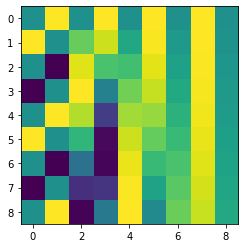

In [3]:
pos_encodings = positional_encoding(9, 9)
plt.imshow(pos_encodings[0])

# ThoughtNet layers

In [4]:
class ThoughtBranchLayer(tf.keras.layers.Layer):
    def __init__(self, embedding_dims, positional_encoding_dims, num_inner_layers, name=None):
        super(ThoughtBranchLayer, self).__init__(name=name)
        
        self.embedding_dims = embedding_dims
        self.positional_encoding_dims = positional_encoding_dims
        
        self.input_with_positional_encoding_layer = Concatenate(axis=-1, name="input_with_positional_encoding")
        
        key_dim = embedding_dims + positional_encoding_dims
        num_heads = 3
        attention_output_dim = key_dim * num_heads
        inner_dim = attention_output_dim * 2

        self.operand_attention_layer = MultiHeadAttention(
            name='operand_attention',
            num_heads=num_heads,
            key_dim=key_dim,
            output_shape=attention_output_dim,
            kernel_regularizer=tf.keras.regularizers.l2(1e-7),
        )

#         self.original_operand_attention_layer = MultiHeadAttention(
#             name='original_operand_attention',
#             num_heads=num_heads,
#             key_dim=key_dim,
#             output_shape=attention_output_dim,
#             kernel_regularizer=tf.keras.regularizers.l2(1e-7),
#         )
        
        self.input_concatenation_layer = Concatenate(axis=-1)
        
        self.dense_layers = []
        for i in range(num_inner_layers):
            if i < num_inner_layers - 1:
                layer_dim = inner_dim
            else:
                layer_dim = embedding_dims
            self.dense_layers.append(Dense(
                layer_dim,
                activation='tanh',
                name=('thought_branch_dense_' + str(i)),
                kernel_regularizer=tf.keras.regularizers.l2(1e-7),
            ))
            
        self.integration_layer = Dense(
            embedding_dims,
            activation='tanh',
            name='integration_layer',
            kernel_regularizer=tf.keras.regularizers.l2(1e-7),
        )
    
    def call(self, original_input_words, input_words, positional_encodings):
        m, num_words, embedding_dims  = input_words.shape
        assert embedding_dims == self.embedding_dims
        assert positional_encodings.shape[1] == num_words
        _, _, positional_encoding_dims = positional_encodings.shape
        assert positional_encoding_dims == self.positional_encoding_dims
        
        repeated_positional_encodings = tf.repeat(positional_encodings, tf.shape(input_words)[0], axis=0)
        
        input_with_positional_encodings = self.input_with_positional_encoding_layer([input_words, repeated_positional_encodings])
        original_input_with_positional_encodings = self.input_with_positional_encoding_layer([original_input_words, repeated_positional_encodings])

        operand = self.operand_attention_layer(
            input_with_positional_encodings, input_with_positional_encodings)
#         original_operand = self.original_operand_attention_layer(
#             input_with_positional_encodings, original_input_with_positional_encodings)
        x = self.input_concatenation_layer([input_with_positional_encodings, operand])
        #x = self.input_concatenation_layer([input_with_positional_encodings, operand, original_operand])
        
        for d in self.dense_layers:
            x = d(x)
            
        # Finally, integrate the new information with the previous accumulator state
        x = self.integration_layer(tf.concat([input_words, x], axis=-1))
        
        return x
    
class ThoughtBranchSelectorLayer(tf.keras.layers.Layer):
    def __init__(self, num_branches, embedding_dims, positional_encoding_dims, branch_selection_noise):
        super(ThoughtBranchSelectorLayer, self).__init__()
        
        self.num_branches = num_branches
        
        self.accumulator_with_positional_encoding_layer = Concatenate(axis=-1, name="accumulator_with_positional_encoding")
        
        self.branch_selection_noise = branch_selection_noise

        key_dim = embedding_dims + positional_encoding_dims
        num_heads = 3
        attention_output_dim = key_dim * num_heads
        inner_dim = attention_output_dim * 2

        self.context_attention_layer = MultiHeadAttention(
            name='additional_context_attention',
            num_heads=num_heads,
            key_dim=key_dim,
            output_shape=attention_output_dim,
            kernel_regularizer=tf.keras.regularizers.l2(1e-7),
        )
        
        self.context_layer = Concatenate(axis=-1)
        self.intermediate_layer = Dense(
            inner_dim,
            activation='tanh',
            name='intermediate',
            kernel_regularizer=tf.keras.regularizers.l2(1e-7),
        )
        self.branch_scores_layer = Dense(
            num_branches,
            name='branch_scores',
            kernel_regularizer=tf.keras.regularizers.l2(1e-7),
        )

    def call(self, prev_accumulator, positional_encodings, training):
        # Note that we apply branch selection using the *previous* iteration's output, not the current one.
        
        repeated_positional_encodings = tf.repeat(positional_encodings, tf.shape(prev_accumulator)[0], axis=0)
        accumulator_with_positional_encoding = self.accumulator_with_positional_encoding_layer([prev_accumulator, repeated_positional_encodings])

        # Calculate one score for each word on each branch
        additional_context = self.context_attention_layer(accumulator_with_positional_encoding, accumulator_with_positional_encoding)
        context = self.context_layer([accumulator_with_positional_encoding, additional_context])
        intermediate_values = self.intermediate_layer(context)
        branch_scores = self.branch_scores_layer(intermediate_values)

        if training:
            noise = tf.random.normal(
                shape=tf.shape(branch_scores),
                mean=0.0,
                stddev=self.branch_selection_noise,
                dtype=tf.float32,
            )
            branch_scores += tf.stop_gradient(noise)
            
        branch_scores = tf.nn.softmax(branch_scores)
        
        return branch_scores

class ThoughtLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        num_branches,
        embedding_dims,
        positional_encoding_dims,
        max_iterations,
        num_inner_layers,
        urgency=1e-3,
        early_stopping_threshold=0.2,
        branch_selection_noise=0.5,
        state_read_noise=0.0,
    ):
        super(ThoughtLayer, self).__init__()

        self.max_iterations = max_iterations
        self.num_branches = num_branches
        self.num_special_branches = 1
        self.embedding_dims = embedding_dims
        self.state_read_noise = state_read_noise
        
        self.branches = [
            ThoughtBranchLayer(
                embedding_dims,
                positional_encoding_dims,
                num_inner_layers,
                name=('branch_' + str(i)),
            )
            for i in range(num_branches)
        ]
        
        self.selector = ThoughtBranchSelectorLayer(
            num_branches + self.num_special_branches,
            embedding_dims,
            positional_encoding_dims,
            branch_selection_noise=branch_selection_noise,
        )

        self.urgency = urgency
        self.early_stopping_threshold = early_stopping_threshold
        
    def compute_thought_cost(self, activity):
        # The goal of this regularizer is to favor sparse use of the available iterations.
        # Assign no cost to using the zero branch, and some cost to using any of the other branches.
        masked_activity = activity[:, :, 1:]
        return tf.reduce_mean(tf.reduce_sum(tf.abs(masked_activity), axis=(-1, -2)))

    def call(self, input_words, positional_encodings, training):
        trace_branch_scores = tf.TensorArray(tf.float32, size=self.max_iterations)
        trace_branch_outputs = tf.TensorArray(tf.float32, size=self.max_iterations)
        trace_iteration_output = tf.TensorArray(tf.float32, size=self.max_iterations)
        trace_accumulator = tf.TensorArray(tf.float32, size=self.max_iterations)
        
        num_words = input_words.shape[1]
        accumulator = input_words
        keep_thinking = tf.constant(True, dtype=tf.bool)
        current_iteration = tf.constant(0, dtype=tf.int32)
        thought_cost = 0.0
        while keep_thinking:
            # Initialize with the special branches
            branch_outputs = [accumulator]

            if training:
                # Add noise to the state that is available to the branches
                noise = tf.random.normal(
                    shape=tf.shape(accumulator),
                    mean=0.0,
                    stddev=self.state_read_noise,
                    dtype=tf.float32,
                )
                accumulator += tf.stop_gradient(noise)
            
            # Process each branch
            for b in self.branches:
                branch_outputs.append(b(input_words, accumulator, positional_encodings))

            branch_scores = self.selector(accumulator, positional_encodings)
            
            iteration_thought_cost = self.compute_thought_cost(branch_scores)
            
            concat_branches = Concatenate()(branch_outputs)
            reshaped_branch_scores = Reshape((num_words, len(branch_outputs), 1))(branch_scores)
            reshaped_branch_outputs = Reshape((num_words, len(branch_outputs), self.embedding_dims))(concat_branches)
            merged_branches = tf.matmul(reshaped_branch_scores, reshaped_branch_outputs, transpose_a=True)
            # Strip the branch dimension
            iteration_output = Reshape((num_words, self.embedding_dims))(merged_branches)

            accumulator = iteration_output
            
            # Keep a trace during inference
            if not training:
                trace_branch_scores = trace_branch_scores.write(current_iteration, branch_scores)
                trace_branch_outputs = trace_branch_outputs.write(current_iteration, reshaped_branch_outputs)
                trace_iteration_output = trace_iteration_output.write(current_iteration, iteration_output)
                trace_accumulator = trace_accumulator.write(current_iteration, accumulator)
    
            # Prepare for next iteration...
            current_iteration = current_iteration + 1
            # Weigh thought cost by the current iteration, to encourage early stopping
            thought_cost = thought_cost + tf.cast(current_iteration, tf.float32) * iteration_thought_cost
            # Check if we should keep thinking.
            # We stop thinking if either:
            # * we have run out of available iterations (max_iterations), or
            # * we decided to not expand any significant thought cost in this iteration
            #   (i.e., we reached a steady state)
            # TODO: Decide separately for each sample in the batch. Currently, this logic doesn't work with batches.
            if training:
                not_reached_steady_state = True
            else:
                not_reached_steady_state = iteration_thought_cost > self.early_stopping_threshold
            keep_thinking = tf.logical_and(current_iteration < self.max_iterations, not_reached_steady_state)

        self.add_metric(current_iteration, "num_iterations")
            
        thought_cost = self.urgency * thought_cost
        self.add_metric(thought_cost, "thought_cost")
        self.add_loss(thought_cost)
        
        if not training:
            # Restructure trace into Python dictionaries for easier access
            branch_trace = [
                {
                    'iteration': i,
                    'branch_scores': trace_branch_scores.read(i),
                    'branch_outputs': trace_branch_outputs.read(i),
                    'iteration_output': trace_iteration_output.read(i),
                    'merged_output': trace_accumulator.read(i),
                }
                for i in range(self.max_iterations)
            ]
        else:
            branch_trace = []

        return [accumulator, branch_trace]

class ExpansionLayer(tf.keras.layers.Layer):
    def __init__(self, input_dims, embedding_dims, activation=None, learn_embedding=False):
        super(ExpansionLayer, self).__init__()

        if learn_embedding:
            self.expansion_layer = Dense(
                embedding_dims,
                activation=activation,
                kernel_regularizer=tf.keras.regularizers.l2(1e-5),
                bias_regularizer=tf.keras.regularizers.l2(1e-5),
                kernel_initializer=tf.keras.initializers.Identity()
            )
        else:
            assert embedding_dims >= input_dims
            self.expansion_layer = Lambda(lambda x: tf.pad(x, [[0, 0], [0, 0], [0, embedding_dims - input_dims]]))

    def call(self, input_words):
        return self.expansion_layer(input_words)

class ReductionLayer(tf.keras.layers.Layer):
    def __init__(self, embedding_dims, output_dims, activation=None, learn_reduction=False):
        super(ReductionLayer, self).__init__()

        if learn_reduction:
            self.reduction_layer = Dense(
                output_dims,
                activation=activation,
                kernel_regularizer=tf.keras.regularizers.l2(1e-5),
                bias_regularizer=tf.keras.regularizers.l2(1e-5),
                kernel_initializer=tf.keras.initializers.Identity()
            )
        else:
            assert embedding_dims >= output_dims
            self.reduction_layer = Lambda(lambda x: x[:, :, 0:output_dims])

    def call(self, x):
        return self.reduction_layer(x)

In [5]:
def plot_branch_trace(branch_trace):
    num_iterations = len(branch_trace)
    num_branches = branch_trace[0]['branch_scores'].shape[2]
    num_words = branch_trace[0]['branch_scores'].shape[1]
    embedding_dim = branch_trace[0]['merged_output'].shape[2]
    fig, axs = plt.subplots(num_words, 2, figsize=[num_words, 20])
    for ax in axs:
        ax[0].set(xlabel='branch', ylabel='iter')
        ax[1].set(xlabel='', ylabel='iter')
    for word_to_trace in range(0, num_words):
        iteration_traces = np.zeros((num_iterations, num_branches))
        accumulator_traces = np.zeros((num_iterations, embedding_dim))
        for i in range(0, num_iterations):
            iteration_traces[i] = tf.reshape(branch_trace[i]['branch_scores'][:, word_to_trace, :], [num_branches])
            accumulator_traces[i] = tf.reshape(branch_trace[i]['merged_output'][:, word_to_trace, :], [embedding_dim])

        axs[word_to_trace, 0].set_title('Branch scores w=' + str(word_to_trace))
        axs[word_to_trace, 0].matshow(iteration_traces, cmap='inferno', vmin=0., vmax=1.)
        axs[word_to_trace, 1].set_title('Accumulator values w=' + str(word_to_trace))
        axs[word_to_trace, 1].matshow(accumulator_traces, cmap='RdYlGn', vmin=-5., vmax=5.)

    plt.tight_layout()
    plt.show()

# Overall model

In [6]:
def make_model(
    num_words,
    word_dim,
    scratch_dim=None,
    num_branches=5,
    max_iterations=5,
    num_inner_layers=2,
    learn_embeddings=False,
    apply_softmax=False,
    urgency=1e-2,
    branch_selection_noise=0.0,
    state_read_noise=0.1,
):
    pos_encoding_dim = num_words
    if not scratch_dim:
        scratch_dim = word_dim
    embedding_dim = word_dim + scratch_dim
    
    pos_encodings = positional_encoding(num_words, pos_encoding_dim)
    
    words_input = Input(shape=(num_words, word_dim))
    pos_encodings = tf.constant(pos_encodings)
    
    x = ExpansionLayer(word_dim, embedding_dim, learn_embedding=learn_embeddings)(words_input)

    thought_layer = ThoughtLayer(num_branches, embedding_dim, pos_encoding_dim, max_iterations, num_inner_layers, urgency=urgency, branch_selection_noise=branch_selection_noise, state_read_noise=state_read_noise)
    x, branch_trace = thought_layer(x, pos_encodings)
    
    #thought_layer2 = ThoughtLayer(num_branches, embedding_dim, pos_encoding_dim, max_iterations, num_inner_layers, activation=activation)
    #x = thought_layer2(x, pos_encodings)
    
    x = ReductionLayer(embedding_dim, word_dim, learn_reduction=learn_embeddings)(x)
    
    # For one-hot output.
    if apply_softmax:
        x = Softmax()(x)
    
    return tf.keras.models.Model(inputs=[words_input], outputs=x), tf.keras.models.Model(inputs=[words_input], outputs=branch_trace)

# Arithmetic example

In [7]:
NUM_DIGITS = 4

def int_to_digits(i, num_digits=NUM_DIGITS):
    i_digits = [int(c) for c in str(i)]
    while len(i_digits) < num_digits:
        i_digits = [0] + i_digits
    return i_digits

def num_to_vec(a, b, c, operation=10):
    x = tf.one_hot([int_to_digits(a) + [operation] + int_to_digits(b)], 12)
    y = tf.one_hot([int_to_digits(c, NUM_DIGITS * 2 + 1)], 12)

    return (x, y)

def vec_to_num(y):
    digits = [np.argmax(v) for v in y]
    s = ''
    for d in digits:
        if d == 10:
            s += '+'
        elif d == 11:
            s += '*'
        else:
            s += str(d)
    return s

def generate_add_samples(max_a, max_b, m):
    X = np.zeros((m, NUM_DIGITS * 2 + 1, 12))
    Y = np.zeros((m, NUM_DIGITS * 2 + 1, 12))
    for i in range(0, m):
        a = np.random.randint(0, max_a)
        b = np.random.randint(0, max_b)
        c = a + b
        X[i], Y[i] = num_to_vec(a, b, c, operation=10)
    return X, Y

def generate_mul_samples(max_a, max_b, m):
    X = np.zeros((m, NUM_DIGITS * 2 + 1, 12))
    Y = np.zeros((m, NUM_DIGITS * 2 + 1, 12))
    for i in range(0, m):
        a = np.random.randint(0, max_a)
        b = np.random.randint(0, max_b)
        c = a * b
        X[i], Y[i] = num_to_vec(a, b, c, operation=11)
    return X, Y

In [8]:
X1, Y1 = generate_mul_samples(10, 10, 500)
X2, Y2 = generate_mul_samples(100, 10, 1000)
X3, Y3 = generate_mul_samples(10, 100, 1000)
X4, Y4 = generate_mul_samples(100, 100, 5000)
X_mul = np.concatenate((X1, X2, X3, X4), axis=0)
Y_mul = np.concatenate((Y1, Y2, Y3, Y4), axis=0)

X1, Y1 = generate_add_samples(10, 10, 500)
X2, Y2 = generate_add_samples(100, 100, 2000)
X3, Y3 = generate_add_samples(1000, 1000, 5000)
X_add = np.concatenate((X1, X2, X3), axis=0)
Y_add = np.concatenate((Y1, Y2, Y3), axis=0)

X = np.concatenate((X_add, X_mul), axis=0)
Y = np.concatenate((Y_add, Y_mul), axis=0)

print(X.shape)
print(Y.shape)

(15000, 9, 12)
(15000, 9, 12)


In [23]:
model, trace_model = make_model(
    9,
    12,
    scratch_dim=25,
    num_branches=10,
    max_iterations=8,
    num_inner_layers=3,
    learn_embeddings=True,
    apply_softmax=True,
    urgency=2e-4,
    branch_selection_noise=0.0,
    state_read_noise=0.4,
)

In [24]:
def categorical_accuracy_per_sequence(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.reduce_all(tf.equal(tf.argmax(y_true, axis=-1),
                  tf.argmax(y_pred, axis=-1)), axis=-1), 'float32'), axis=-1)

batch_size = 250
epoch_boundaries = [500, 750]
#epoch_boundaries = [250, 400]
step_boundaries = [e * X.shape[0] / batch_size for e in epoch_boundaries]

learning_rate_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    step_boundaries, [0.0005, 0.0001, 0.00002], name=None
)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule, clipnorm=1.0)
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizer,
    metrics = ['accuracy', categorical_accuracy_per_sequence],
    steps_per_execution=1,
)

In [25]:
#log_dir = "thoughtnet_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "thoughtnet_logs/fit/0.4_noise"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit([X], Y, epochs=1000, batch_size=batch_size, callbacks=[tensorboard_callback])

Epoch 1/1000
60/60 [==============================] - 46s 180ms/step - loss: 1.4317 - accuracy: 0.6744 - categorical_accuracy_per_sequence: 0.0239 - num_iterations: 8.0000 - thought_cost: 0.0327
Epoch 2/1000
60/60 [==============================] - 11s 178ms/step - loss: 0.9754 - accuracy: 0.6897 - categorical_accuracy_per_sequence: 0.0232 - num_iterations: 8.0000 - thought_cost: 0.0156
Epoch 3/1000
60/60 [==============================] - 11s 179ms/step - loss: 0.9125 - accuracy: 0.6903 - categorical_accuracy_per_sequence: 0.0241 - num_iterations: 8.0000 - thought_cost: 0.0074
Epoch 4/1000
60/60 [==============================] - 11s 180ms/step - loss: 0.8822 - accuracy: 0.6923 - categorical_accuracy_per_sequence: 0.0247 - num_iterations: 8.0000 - thought_cost: 0.0048
Epoch 5/1000
60/60 [==============================] - 11s 181ms/step - loss: 0.8658 - accuracy: 0.6936 - categorical_accuracy_per_sequence: 0.0245 - num_iterations: 8.0000 - thought_cost: 0.0043
Epoch 6/1000
60/60 [=====

60/60 [==============================] - 11s 189ms/step - loss: 0.3121 - accuracy: 0.8818 - categorical_accuracy_per_sequence: 0.3061 - num_iterations: 8.0000 - thought_cost: 0.0038
Epoch 43/1000
60/60 [==============================] - 11s 189ms/step - loss: 0.3044 - accuracy: 0.8850 - categorical_accuracy_per_sequence: 0.3160 - num_iterations: 8.0000 - thought_cost: 0.0037
Epoch 44/1000
60/60 [==============================] - 11s 188ms/step - loss: 0.2984 - accuracy: 0.8868 - categorical_accuracy_per_sequence: 0.3257 - num_iterations: 8.0000 - thought_cost: 0.0037
Epoch 45/1000
60/60 [==============================] - 11s 187ms/step - loss: 0.2943 - accuracy: 0.8883 - categorical_accuracy_per_sequence: 0.3348 - num_iterations: 8.0000 - thought_cost: 0.0037
Epoch 46/1000
60/60 [==============================] - 11s 188ms/step - loss: 0.2898 - accuracy: 0.8895 - categorical_accuracy_per_sequence: 0.3412 - num_iterations: 8.0000 - thought_cost: 0.0037
Epoch 47/1000
60/60 [=============

60/60 [==============================] - 11s 188ms/step - loss: 0.1952 - accuracy: 0.9291 - categorical_accuracy_per_sequence: 0.5570 - num_iterations: 8.0000 - thought_cost: 0.0036
Epoch 84/1000
60/60 [==============================] - 11s 189ms/step - loss: 0.1931 - accuracy: 0.9299 - categorical_accuracy_per_sequence: 0.5643 - num_iterations: 8.0000 - thought_cost: 0.0035
Epoch 85/1000
60/60 [==============================] - 11s 188ms/step - loss: 0.1918 - accuracy: 0.9310 - categorical_accuracy_per_sequence: 0.5697 - num_iterations: 8.0000 - thought_cost: 0.0035
Epoch 86/1000
60/60 [==============================] - 11s 188ms/step - loss: 0.1904 - accuracy: 0.9309 - categorical_accuracy_per_sequence: 0.5697 - num_iterations: 8.0000 - thought_cost: 0.0035
Epoch 87/1000
60/60 [==============================] - 11s 187ms/step - loss: 0.1872 - accuracy: 0.9329 - categorical_accuracy_per_sequence: 0.5811 - num_iterations: 8.0000 - thought_cost: 0.0035
Epoch 88/1000
60/60 [=============

60/60 [==============================] - 11s 188ms/step - loss: 0.1317 - accuracy: 0.9532 - categorical_accuracy_per_sequence: 0.7061 - num_iterations: 8.0000 - thought_cost: 0.0031
Epoch 125/1000
60/60 [==============================] - 11s 188ms/step - loss: 0.1303 - accuracy: 0.9545 - categorical_accuracy_per_sequence: 0.7120 - num_iterations: 8.0000 - thought_cost: 0.0031
Epoch 126/1000
60/60 [==============================] - 11s 188ms/step - loss: 0.1327 - accuracy: 0.9534 - categorical_accuracy_per_sequence: 0.7065 - num_iterations: 8.0000 - thought_cost: 0.0030
Epoch 127/1000
60/60 [==============================] - 11s 188ms/step - loss: 0.1272 - accuracy: 0.9557 - categorical_accuracy_per_sequence: 0.7163 - num_iterations: 8.0000 - thought_cost: 0.0031
Epoch 128/1000
60/60 [==============================] - 11s 188ms/step - loss: 0.1270 - accuracy: 0.9555 - categorical_accuracy_per_sequence: 0.7132 - num_iterations: 8.0000 - thought_cost: 0.0031
Epoch 129/1000
60/60 [========

60/60 [==============================] - 11s 187ms/step - loss: 0.0939 - accuracy: 0.9687 - categorical_accuracy_per_sequence: 0.7856 - num_iterations: 8.0000 - thought_cost: 0.0030
Epoch 166/1000
60/60 [==============================] - 11s 187ms/step - loss: 0.0917 - accuracy: 0.9693 - categorical_accuracy_per_sequence: 0.7921 - num_iterations: 8.0000 - thought_cost: 0.0030
Epoch 167/1000
60/60 [==============================] - 11s 186ms/step - loss: 0.0907 - accuracy: 0.9697 - categorical_accuracy_per_sequence: 0.7907 - num_iterations: 8.0000 - thought_cost: 0.0030
Epoch 168/1000
60/60 [==============================] - 11s 187ms/step - loss: 0.0921 - accuracy: 0.9693 - categorical_accuracy_per_sequence: 0.7922 - num_iterations: 8.0000 - thought_cost: 0.0030
Epoch 169/1000
60/60 [==============================] - 11s 187ms/step - loss: 0.0903 - accuracy: 0.9698 - categorical_accuracy_per_sequence: 0.7937 - num_iterations: 8.0000 - thought_cost: 0.0030
Epoch 170/1000
60/60 [========

60/60 [==============================] - 11s 186ms/step - loss: 0.0678 - accuracy: 0.9786 - categorical_accuracy_per_sequence: 0.8451 - num_iterations: 8.0000 - thought_cost: 0.0030
Epoch 207/1000
60/60 [==============================] - 11s 187ms/step - loss: 0.0703 - accuracy: 0.9781 - categorical_accuracy_per_sequence: 0.8422 - num_iterations: 8.0000 - thought_cost: 0.0029
Epoch 208/1000
60/60 [==============================] - 11s 186ms/step - loss: 0.0675 - accuracy: 0.9794 - categorical_accuracy_per_sequence: 0.8502 - num_iterations: 8.0000 - thought_cost: 0.0029
Epoch 209/1000
60/60 [==============================] - 11s 186ms/step - loss: 0.0667 - accuracy: 0.9792 - categorical_accuracy_per_sequence: 0.8492 - num_iterations: 8.0000 - thought_cost: 0.0029
Epoch 210/1000
60/60 [==============================] - 11s 187ms/step - loss: 0.0653 - accuracy: 0.9800 - categorical_accuracy_per_sequence: 0.8527 - num_iterations: 8.0000 - thought_cost: 0.0029
Epoch 211/1000
60/60 [========

60/60 [==============================] - 11s 186ms/step - loss: 0.0510 - accuracy: 0.9851 - categorical_accuracy_per_sequence: 0.8874 - num_iterations: 8.0000 - thought_cost: 0.0028
Epoch 248/1000
60/60 [==============================] - 11s 186ms/step - loss: 0.0515 - accuracy: 0.9852 - categorical_accuracy_per_sequence: 0.8875 - num_iterations: 8.0000 - thought_cost: 0.0029
Epoch 249/1000
60/60 [==============================] - 11s 186ms/step - loss: 0.0545 - accuracy: 0.9841 - categorical_accuracy_per_sequence: 0.8804 - num_iterations: 8.0000 - thought_cost: 0.0028
Epoch 250/1000
60/60 [==============================] - 11s 187ms/step - loss: 0.0515 - accuracy: 0.9857 - categorical_accuracy_per_sequence: 0.8917 - num_iterations: 8.0000 - thought_cost: 0.0028
Epoch 251/1000
60/60 [==============================] - 11s 187ms/step - loss: 0.0505 - accuracy: 0.9855 - categorical_accuracy_per_sequence: 0.8885 - num_iterations: 8.0000 - thought_cost: 0.0029
Epoch 252/1000
60/60 [========

60/60 [==============================] - 11s 186ms/step - loss: 0.0399 - accuracy: 0.9903 - categorical_accuracy_per_sequence: 0.9232 - num_iterations: 8.0000 - thought_cost: 0.0028
Epoch 289/1000
60/60 [==============================] - 11s 186ms/step - loss: 0.0414 - accuracy: 0.9892 - categorical_accuracy_per_sequence: 0.9145 - num_iterations: 8.0000 - thought_cost: 0.0027
Epoch 290/1000
60/60 [==============================] - 11s 186ms/step - loss: 0.0420 - accuracy: 0.9892 - categorical_accuracy_per_sequence: 0.9144 - num_iterations: 8.0000 - thought_cost: 0.0028
Epoch 291/1000
60/60 [==============================] - 11s 186ms/step - loss: 0.0405 - accuracy: 0.9898 - categorical_accuracy_per_sequence: 0.9175 - num_iterations: 8.0000 - thought_cost: 0.0027
Epoch 292/1000
60/60 [==============================] - 11s 186ms/step - loss: 0.0410 - accuracy: 0.9896 - categorical_accuracy_per_sequence: 0.9173 - num_iterations: 8.0000 - thought_cost: 0.0027
Epoch 293/1000
60/60 [========

60/60 [==============================] - 11s 187ms/step - loss: 0.0350 - accuracy: 0.9918 - categorical_accuracy_per_sequence: 0.9339 - num_iterations: 8.0000 - thought_cost: 0.0026
Epoch 330/1000
60/60 [==============================] - 11s 186ms/step - loss: 0.0324 - accuracy: 0.9929 - categorical_accuracy_per_sequence: 0.9427 - num_iterations: 8.0000 - thought_cost: 0.0027
Epoch 331/1000
60/60 [==============================] - 11s 186ms/step - loss: 0.0321 - accuracy: 0.9932 - categorical_accuracy_per_sequence: 0.9442 - num_iterations: 8.0000 - thought_cost: 0.0027
Epoch 332/1000
60/60 [==============================] - 11s 186ms/step - loss: 0.0314 - accuracy: 0.9934 - categorical_accuracy_per_sequence: 0.9447 - num_iterations: 8.0000 - thought_cost: 0.0026
Epoch 333/1000
60/60 [==============================] - 11s 187ms/step - loss: 0.0334 - accuracy: 0.9932 - categorical_accuracy_per_sequence: 0.9436 - num_iterations: 8.0000 - thought_cost: 0.0027
Epoch 334/1000
60/60 [========

60/60 [==============================] - 11s 186ms/step - loss: 0.0305 - accuracy: 0.9940 - categorical_accuracy_per_sequence: 0.9505 - num_iterations: 8.0000 - thought_cost: 0.0027
Epoch 371/1000
60/60 [==============================] - 11s 186ms/step - loss: 0.0292 - accuracy: 0.9944 - categorical_accuracy_per_sequence: 0.9536 - num_iterations: 8.0000 - thought_cost: 0.0026
Epoch 372/1000
60/60 [==============================] - 11s 187ms/step - loss: 0.0294 - accuracy: 0.9944 - categorical_accuracy_per_sequence: 0.9529 - num_iterations: 8.0000 - thought_cost: 0.0026
Epoch 373/1000
60/60 [==============================] - 11s 187ms/step - loss: 0.0288 - accuracy: 0.9945 - categorical_accuracy_per_sequence: 0.9553 - num_iterations: 8.0000 - thought_cost: 0.0026
Epoch 374/1000
60/60 [==============================] - 11s 187ms/step - loss: 0.0294 - accuracy: 0.9945 - categorical_accuracy_per_sequence: 0.9552 - num_iterations: 8.0000 - thought_cost: 0.0026
Epoch 375/1000
60/60 [========

60/60 [==============================] - 11s 187ms/step - loss: 0.0261 - accuracy: 0.9957 - categorical_accuracy_per_sequence: 0.9645 - num_iterations: 8.0000 - thought_cost: 0.0025
Epoch 412/1000
60/60 [==============================] - 11s 188ms/step - loss: 0.0250 - accuracy: 0.9959 - categorical_accuracy_per_sequence: 0.9660 - num_iterations: 8.0000 - thought_cost: 0.0025
Epoch 413/1000
60/60 [==============================] - 11s 188ms/step - loss: 0.0241 - accuracy: 0.9961 - categorical_accuracy_per_sequence: 0.9670 - num_iterations: 8.0000 - thought_cost: 0.0025
Epoch 414/1000
60/60 [==============================] - 11s 188ms/step - loss: 0.0252 - accuracy: 0.9959 - categorical_accuracy_per_sequence: 0.9659 - num_iterations: 8.0000 - thought_cost: 0.0025
Epoch 415/1000
60/60 [==============================] - 11s 187ms/step - loss: 0.0255 - accuracy: 0.9955 - categorical_accuracy_per_sequence: 0.9627 - num_iterations: 8.0000 - thought_cost: 0.0025
Epoch 416/1000
60/60 [========

60/60 [==============================] - 11s 187ms/step - loss: 0.0236 - accuracy: 0.9964 - categorical_accuracy_per_sequence: 0.9701 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 453/1000
60/60 [==============================] - 11s 187ms/step - loss: 0.0227 - accuracy: 0.9965 - categorical_accuracy_per_sequence: 0.9695 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 454/1000
60/60 [==============================] - 11s 188ms/step - loss: 0.0234 - accuracy: 0.9963 - categorical_accuracy_per_sequence: 0.9689 - num_iterations: 8.0000 - thought_cost: 0.0025
Epoch 455/1000
60/60 [==============================] - 11s 186ms/step - loss: 0.0245 - accuracy: 0.9962 - categorical_accuracy_per_sequence: 0.9681 - num_iterations: 8.0000 - thought_cost: 0.0025
Epoch 456/1000
60/60 [==============================] - 11s 188ms/step - loss: 0.0219 - accuracy: 0.9969 - categorical_accuracy_per_sequence: 0.9734 - num_iterations: 8.0000 - thought_cost: 0.0025
Epoch 457/1000
60/60 [========

60/60 [==============================] - 11s 187ms/step - loss: 0.0212 - accuracy: 0.9972 - categorical_accuracy_per_sequence: 0.9763 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 494/1000
60/60 [==============================] - 11s 186ms/step - loss: 0.0212 - accuracy: 0.9973 - categorical_accuracy_per_sequence: 0.9767 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 495/1000
60/60 [==============================] - 11s 187ms/step - loss: 0.0202 - accuracy: 0.9975 - categorical_accuracy_per_sequence: 0.9789 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 496/1000
60/60 [==============================] - 11s 187ms/step - loss: 0.0218 - accuracy: 0.9969 - categorical_accuracy_per_sequence: 0.9740 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 497/1000
60/60 [==============================] - 11s 187ms/step - loss: 0.0211 - accuracy: 0.9971 - categorical_accuracy_per_sequence: 0.9761 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 498/1000
60/60 [========

60/60 [==============================] - 11s 187ms/step - loss: 0.0146 - accuracy: 0.9994 - categorical_accuracy_per_sequence: 0.9947 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 535/1000
60/60 [==============================] - 11s 186ms/step - loss: 0.0144 - accuracy: 0.9994 - categorical_accuracy_per_sequence: 0.9945 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 536/1000
60/60 [==============================] - 11s 187ms/step - loss: 0.0143 - accuracy: 0.9994 - categorical_accuracy_per_sequence: 0.9947 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 537/1000
60/60 [==============================] - 11s 187ms/step - loss: 0.0142 - accuracy: 0.9995 - categorical_accuracy_per_sequence: 0.9959 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 538/1000
60/60 [==============================] - 11s 187ms/step - loss: 0.0146 - accuracy: 0.9994 - categorical_accuracy_per_sequence: 0.9951 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 539/1000
60/60 [========

60/60 [==============================] - 11s 188ms/step - loss: 0.0135 - accuracy: 0.9997 - categorical_accuracy_per_sequence: 0.9973 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 576/1000
60/60 [==============================] - 11s 188ms/step - loss: 0.0139 - accuracy: 0.9995 - categorical_accuracy_per_sequence: 0.9961 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 577/1000
60/60 [==============================] - 11s 189ms/step - loss: 0.0145 - accuracy: 0.9994 - categorical_accuracy_per_sequence: 0.9953 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 578/1000
60/60 [==============================] - 11s 188ms/step - loss: 0.0139 - accuracy: 0.9995 - categorical_accuracy_per_sequence: 0.9954 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 579/1000
60/60 [==============================] - 11s 189ms/step - loss: 0.0140 - accuracy: 0.9995 - categorical_accuracy_per_sequence: 0.9953 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 580/1000
60/60 [========

60/60 [==============================] - 11s 188ms/step - loss: 0.0137 - accuracy: 0.9995 - categorical_accuracy_per_sequence: 0.9957 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 617/1000
60/60 [==============================] - 11s 188ms/step - loss: 0.0139 - accuracy: 0.9994 - categorical_accuracy_per_sequence: 0.9947 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 618/1000
60/60 [==============================] - 11s 188ms/step - loss: 0.0138 - accuracy: 0.9995 - categorical_accuracy_per_sequence: 0.9952 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 619/1000
60/60 [==============================] - 11s 188ms/step - loss: 0.0141 - accuracy: 0.9994 - categorical_accuracy_per_sequence: 0.9950 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 620/1000
60/60 [==============================] - 11s 189ms/step - loss: 0.0144 - accuracy: 0.9993 - categorical_accuracy_per_sequence: 0.9939 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 621/1000
60/60 [========

60/60 [==============================] - 11s 186ms/step - loss: 0.0136 - accuracy: 0.9995 - categorical_accuracy_per_sequence: 0.9952 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 658/1000
60/60 [==============================] - 11s 186ms/step - loss: 0.0138 - accuracy: 0.9994 - categorical_accuracy_per_sequence: 0.9947 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 659/1000
60/60 [==============================] - 11s 187ms/step - loss: 0.0136 - accuracy: 0.9994 - categorical_accuracy_per_sequence: 0.9952 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 660/1000
60/60 [==============================] - 11s 186ms/step - loss: 0.0133 - accuracy: 0.9996 - categorical_accuracy_per_sequence: 0.9965 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 661/1000
60/60 [==============================] - 11s 187ms/step - loss: 0.0134 - accuracy: 0.9995 - categorical_accuracy_per_sequence: 0.9959 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 662/1000
60/60 [========

60/60 [==============================] - 11s 186ms/step - loss: 0.0135 - accuracy: 0.9994 - categorical_accuracy_per_sequence: 0.9951 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 699/1000
60/60 [==============================] - 11s 186ms/step - loss: 0.0130 - accuracy: 0.9996 - categorical_accuracy_per_sequence: 0.9969 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 700/1000
60/60 [==============================] - 11s 186ms/step - loss: 0.0137 - accuracy: 0.9994 - categorical_accuracy_per_sequence: 0.9953 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 701/1000
60/60 [==============================] - 11s 187ms/step - loss: 0.0141 - accuracy: 0.9993 - categorical_accuracy_per_sequence: 0.9937 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 702/1000
60/60 [==============================] - 11s 186ms/step - loss: 0.0135 - accuracy: 0.9994 - categorical_accuracy_per_sequence: 0.9951 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 703/1000
60/60 [========

60/60 [==============================] - 11s 185ms/step - loss: 0.0131 - accuracy: 0.9996 - categorical_accuracy_per_sequence: 0.9961 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 740/1000
60/60 [==============================] - 11s 186ms/step - loss: 0.0134 - accuracy: 0.9995 - categorical_accuracy_per_sequence: 0.9958 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 741/1000
60/60 [==============================] - 11s 185ms/step - loss: 0.0133 - accuracy: 0.9995 - categorical_accuracy_per_sequence: 0.9955 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 742/1000
60/60 [==============================] - 11s 187ms/step - loss: 0.0130 - accuracy: 0.9995 - categorical_accuracy_per_sequence: 0.9959 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 743/1000
60/60 [==============================] - 11s 186ms/step - loss: 0.0134 - accuracy: 0.9994 - categorical_accuracy_per_sequence: 0.9949 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 744/1000
60/60 [========

60/60 [==============================] - 11s 187ms/step - loss: 0.0121 - accuracy: 0.9998 - categorical_accuracy_per_sequence: 0.9984 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 781/1000
60/60 [==============================] - 11s 187ms/step - loss: 0.0122 - accuracy: 0.9998 - categorical_accuracy_per_sequence: 0.9983 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 782/1000
60/60 [==============================] - 11s 186ms/step - loss: 0.0123 - accuracy: 0.9998 - categorical_accuracy_per_sequence: 0.9981 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 783/1000
60/60 [==============================] - 11s 186ms/step - loss: 0.0121 - accuracy: 0.9998 - categorical_accuracy_per_sequence: 0.9983 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 784/1000
60/60 [==============================] - 11s 185ms/step - loss: 0.0123 - accuracy: 0.9997 - categorical_accuracy_per_sequence: 0.9974 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 785/1000
60/60 [========

60/60 [==============================] - 11s 186ms/step - loss: 0.0121 - accuracy: 0.9998 - categorical_accuracy_per_sequence: 0.9981 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 822/1000
60/60 [==============================] - 11s 186ms/step - loss: 0.0121 - accuracy: 0.9998 - categorical_accuracy_per_sequence: 0.9982 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 823/1000
60/60 [==============================] - 11s 186ms/step - loss: 0.0121 - accuracy: 0.9997 - categorical_accuracy_per_sequence: 0.9976 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 824/1000
60/60 [==============================] - 11s 192ms/step - loss: 0.0120 - accuracy: 0.9998 - categorical_accuracy_per_sequence: 0.9985 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 825/1000
60/60 [==============================] - 12s 199ms/step - loss: 0.0120 - accuracy: 0.9998 - categorical_accuracy_per_sequence: 0.9984 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 826/1000
60/60 [========

60/60 [==============================] - 11s 191ms/step - loss: 0.0118 - accuracy: 0.9999 - categorical_accuracy_per_sequence: 0.9988 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 863/1000
60/60 [==============================] - 11s 190ms/step - loss: 0.0121 - accuracy: 0.9998 - categorical_accuracy_per_sequence: 0.9980 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 864/1000
60/60 [==============================] - 12s 197ms/step - loss: 0.0120 - accuracy: 0.9998 - categorical_accuracy_per_sequence: 0.9986 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 865/1000
60/60 [==============================] - 11s 189ms/step - loss: 0.0120 - accuracy: 0.9998 - categorical_accuracy_per_sequence: 0.9980 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 866/1000
60/60 [==============================] - 12s 193ms/step - loss: 0.0120 - accuracy: 0.9998 - categorical_accuracy_per_sequence: 0.9983 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 867/1000
60/60 [========

60/60 [==============================] - 11s 188ms/step - loss: 0.0118 - accuracy: 0.9999 - categorical_accuracy_per_sequence: 0.9989 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 904/1000
60/60 [==============================] - 11s 188ms/step - loss: 0.0121 - accuracy: 0.9998 - categorical_accuracy_per_sequence: 0.9981 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 905/1000
60/60 [==============================] - 11s 187ms/step - loss: 0.0121 - accuracy: 0.9997 - categorical_accuracy_per_sequence: 0.9975 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 906/1000
60/60 [==============================] - 11s 189ms/step - loss: 0.0119 - accuracy: 0.9998 - categorical_accuracy_per_sequence: 0.9984 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 907/1000
60/60 [==============================] - 11s 188ms/step - loss: 0.0122 - accuracy: 0.9997 - categorical_accuracy_per_sequence: 0.9975 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 908/1000
60/60 [========

60/60 [==============================] - 12s 194ms/step - loss: 0.0118 - accuracy: 0.9998 - categorical_accuracy_per_sequence: 0.9986 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 945/1000
60/60 [==============================] - 11s 192ms/step - loss: 0.0120 - accuracy: 0.9998 - categorical_accuracy_per_sequence: 0.9979 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 946/1000
60/60 [==============================] - 12s 204ms/step - loss: 0.0118 - accuracy: 0.9998 - categorical_accuracy_per_sequence: 0.9983 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 947/1000
60/60 [==============================] - 12s 197ms/step - loss: 0.0119 - accuracy: 0.9998 - categorical_accuracy_per_sequence: 0.9980 - num_iterations: 8.0000 - thought_cost: 0.0023
Epoch 948/1000
60/60 [==============================] - 12s 206ms/step - loss: 0.0120 - accuracy: 0.9998 - categorical_accuracy_per_sequence: 0.9979 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 949/1000
60/60 [========

60/60 [==============================] - 12s 192ms/step - loss: 0.0120 - accuracy: 0.9998 - categorical_accuracy_per_sequence: 0.9979 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 986/1000
60/60 [==============================] - 11s 191ms/step - loss: 0.0119 - accuracy: 0.9998 - categorical_accuracy_per_sequence: 0.9981 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 987/1000
60/60 [==============================] - 11s 192ms/step - loss: 0.0120 - accuracy: 0.9997 - categorical_accuracy_per_sequence: 0.9979 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 988/1000
60/60 [==============================] - 11s 192ms/step - loss: 0.0119 - accuracy: 0.9997 - categorical_accuracy_per_sequence: 0.9977 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 989/1000
60/60 [==============================] - 11s 190ms/step - loss: 0.0117 - accuracy: 0.9999 - categorical_accuracy_per_sequence: 0.9989 - num_iterations: 8.0000 - thought_cost: 0.0024
Epoch 990/1000
60/60 [========

In [25]:
%tensorboard --logdir thoughtnet_logs/fit

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [ ]:
model.save("thoughtnet_model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [38]:
X_val, Y_val = generate_mul_samples(100, 100, 1000)
model.evaluate(X_val, Y_val)

32/32 [==============================] - 1s 20ms/step - loss: 0.3289 - accuracy: 0.9282 - categorical_accuracy_per_sequence: 0.5293 - num_iterations: 2.0000 - thought_cost: 0.0014


[0.3289285898208618,
 0.9282222390174866,
 0.529296875,
 2.0,
 0.0014372816076502204]

1/1 [==============================] - 2s 2s/step
000001914
000001954
1/1 [==============================] - 2s 2s/step


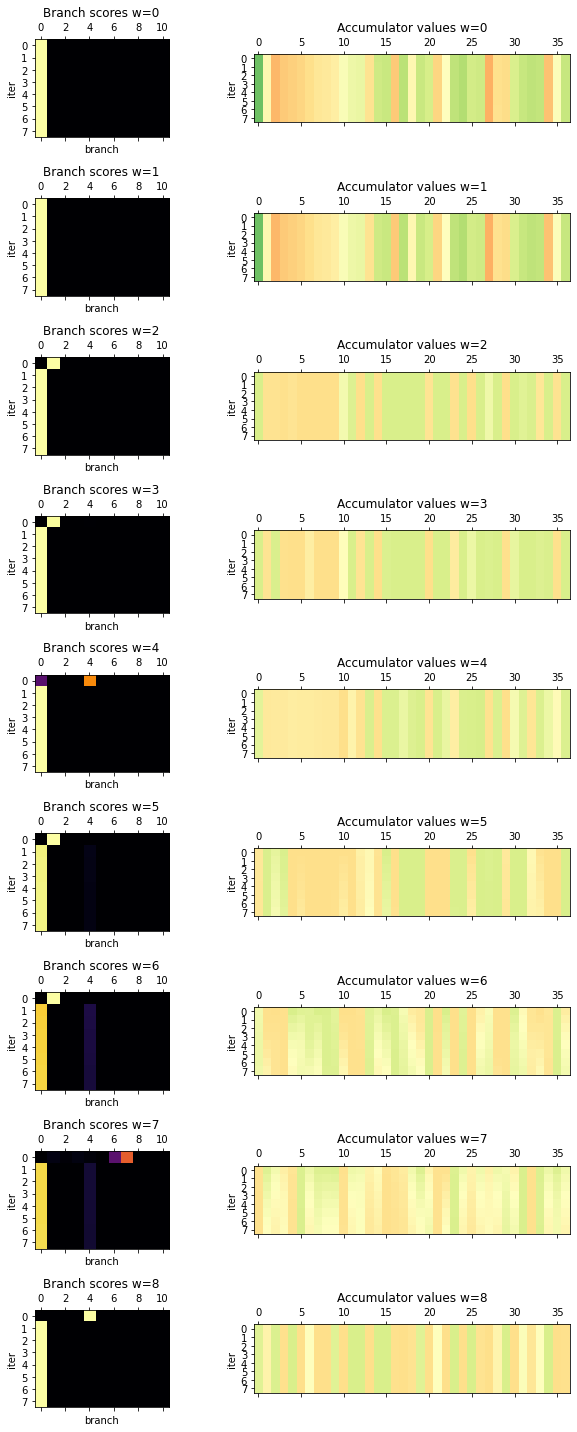

In [39]:
x, yh = num_to_vec(29, 66, 29*66, operation=11)
y = model.predict(x)
print(vec_to_num(yh[0]))
print(vec_to_num(y[0]))

plot_branch_trace(trace_model.predict(x))

In [ ]:
model.get_layer(index=2).weights